## Step 2. EDA train chunks

-----
### read DF

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_path = "/workspace/dataset/"

In [2]:
df = pd.read_csv(data_path + "train_sample.csv")
print(df.shape)
df.head()

(8134818, 11)


,bcateid,brand,dcateid,maker,mcateid,model,pid,price,product,scateid,updttm
0,1,퍼즐라이프,-1,상품상세설명 참조,1,퍼즐라이프 직소퍼즐 바다거북의 여행,b'O4486751463',16520,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275),2,b'20180227091029'
1,3,바보사랑,-1,MORY|해당없음,3,아이폰6S/6S+ tree farm101 - 다이어리케이스|아이폰6S/6S+,b'P3307178849',20370,[모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][...,4,b'20180429085019'
2,5,크리비아,-1,NaN,5,크리비아 기모 3부 속바지 GLG4314P,b'R4424255515',-1,크리비아 기모 3부 속바지 GLG4314P,6,b'20180426102314'
3,7,잭앤질,-1,㈜크리스패션,7,[잭앤질] 남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,b'F3334315393',16280,[하프클럽/잭앤질]남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,8,b'20180422084512'
4,10,NaN,-1,기타,9,SD코드프리혈당시험지[50매],b'N731678492',-1,코드프리혈당시험지50매/코드프리시험지/최장유효기간,11,b'20180424071623'


In [3]:
df.columns

Index(['bcateid', 'brand', 'dcateid', 'maker', 'mcateid', 'model', 'pid',
       'price', 'product', 'scateid', 'updttm'],
      dtype='object')

### show y(cate) distribution

In [4]:
def show_dist_col(df, col_name, remove_empty=True):
    ax = 0
    if remove_empty:
        ax = df[col_name].value_counts()[1:]
    else:
        ax = df[col_name].value_counts()
    print("unique length :", str(len(ax)))

    plt.bar(np.arange(len(ax.index)), ax.values)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)

unique length : 57


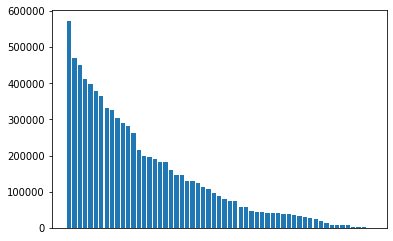

In [5]:
show_dist_col(df, "bcateid", remove_empty=False)

unique length : 552


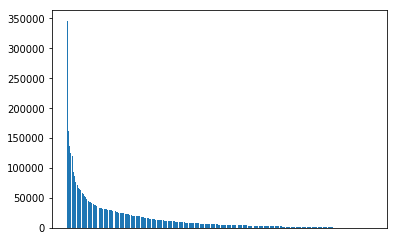

In [6]:
show_dist_col(df, "mcateid", remove_empty=False)

unique length : 3189


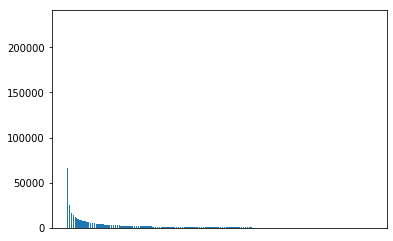

In [7]:
show_dist_col(df, "scateid", remove_empty=True)

unique length : 403


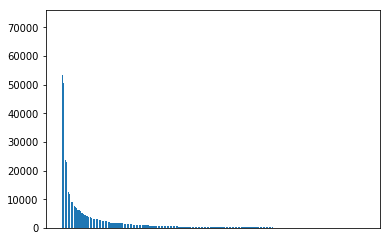

In [8]:
show_dist_col(df, "dcateid", remove_empty=True)

### small, detail cate empty check

In [9]:
s_empty_ratio = df.scateid.value_counts().tolist()[0] / sum(df.scateid.value_counts())
print("small cate's empty ratio :", str(round(s_empty_ratio, 2)))

small cate's empty ratio : 0.23


In [10]:
d_empty_ratio = df.dcateid.value_counts().tolist()[0] / sum(df.dcateid.value_counts())
print("detail cate's empty ratio :", str(round(d_empty_ratio, 2)))

detail cate's empty ratio : 0.91


### make cid (comb all cate)

In [59]:
def concat_cate(b, m, s, d):
    cid = [str(b), str(m), str(s), str(d)]
    return("_".join(cid))

In [60]:
df['cid'] = df.apply(lambda x: concat_cate(x['bcateid'], x['mcateid'], x['scateid'], x['dcateid']), axis=1)

In [64]:
df['cid'].value_counts()[:10]

24_31_34_5       72344
50_201_-1_-1     66904
6_14_149_-1      66451
3_3_38_10        60313
3_3_38_-1        55871
20_132_195_-1    53778
3_3_38_8         53278
3_3_38_6         50747
3_3_375_-1       47568
17_20_53_-1      47516
Name: cid, dtype: int64

In [62]:
len(df['cid'].value_counts())

4215

unique length : 4215


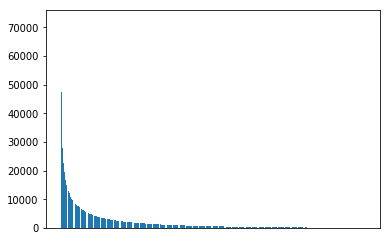

In [63]:
show_dist_col(df, "cid", remove_empty=False)

# Question :  RNN 방식으로 4개의 cell을 예측하면 57, 552, 3190, 404 개의 one-hot을 예측하는 것?
- 만약 그렇다면 조합의 개수 4215개로 하는게 낫지 않나??
- 조합을 한다는 것은 나름의 ruleset을 가지고 structure 구조가 된다는 것인데, 구조가 없는 57 X 552 X 3190 X 404 보다 낫지 않을까??

- cate 조합을 y로 쓰는 것(4215)의 문제점 : 새로운 조합에 대해서는 예측이 불가능?
- cate 조합을 y로 쓰는 것(4215)의 장점 : 이미 어느정도 만들어놓은 association ruleset과 비슷한 효과를 가질 듯?
- RNN 연속성 예측의 문제점 : 학습 연산량이 지나치게 많을 듯?
- RNN 연속성 예측의 장점 : 학습만 제대로 된다면 새로운 조합에 대해서 예측이 가능, 그리고 아마도 더 정확할 듯?
###### RNN 연속성 예측 질문 : cell마다 다른 one-hot size의 output으로 나가는게 가능한가?

- 의견 1 : 아마 Test 데이터 셋에서 새로운 카테고리 조합이 많이 나올 것 같지는 않음.
- 의견 2 : 아마 RNN이 더 정확할 것 같음.
- 그러니 두 방법 모두 다 테스트 해서 성능을 비교해봐야 할 듯.

-----
-----
### EDA x-features

#### check train pid in dev
- insight : dev의 pid는 train에서 한번도 등장하지 않았던 item

In [11]:
df.pid.value_counts()[:10]

b'U3387951161'    1
b'K4566559512'    1
b'F528184536'     1
b'F2317977693'    1
b'K4702899513'    1
b'N2238242579'    1
b'Q4675330774'    1
b'U3737307668'    1
b'R4270129266'    1
b'L4461536018'    1
Name: pid, dtype: int64

In [12]:
dev_df = pd.read_csv(data_path + "dev_sample.csv")

In [13]:
df.pid.value_counts()[:10]

b'U3387951161'    1
b'K4566559512'    1
b'F528184536'     1
b'F2317977693'    1
b'K4702899513'    1
b'N2238242579'    1
b'Q4675330774'    1
b'U3737307668'    1
b'R4270129266'    1
b'L4461536018'    1
Name: pid, dtype: int64

In [14]:
train_pid_dict = dict(df.pid.value_counts())

In [15]:
def check_pid_dict(pid):
    if pid in train_pid_dict:
        return 1
    else:
        return 0

dev_df['used_pid'] = dev_df.pid.apply(lambda x: check_pid_dict(x))

In [16]:
dev_df['used_pid'].value_counts() ## --> dev의 pid는 train에서 한번도 등장하지 않았던 item

0    507783
Name: used_pid, dtype: int64

-----
-----
#### brand eda
- insight : 약 4%정도가 브랜드 쓰레기값 포함
- 약 50%정도가 브랜드 결측

In [17]:
len(df.brand.value_counts()) ## --> 브랜드 종류 약 19만개

193459

In [18]:
brand_list = df.brand.value_counts().index.tolist()

In [19]:
exception_brand_dict = ["참조", "없음", "표기", "별도", "상세", "자체"]
exception_brand_list = []

In [20]:
for brand in brand_list:
    if any(word in brand for word in exception_brand_dict):
        exception_brand_list.append(brand)

In [21]:
df[df['brand'].isin(exception_brand_list)]['brand'].shape[0] / df.shape[0] ## --> 약 4%정도가 브랜드 쓰레기값 포함

0.04116588717780779

In [22]:
df.brand.isnull().sum() / df.shape[0] ## --> 약 50%정도가 브랜드 결측

0.48312340853845775

In [23]:
df.isnull().sum()

bcateid          0
brand      3930121
dcateid          0
maker      2196847
mcateid          0
model      2063426
pid              0
price            0
product          0
scateid          0
updttm           0
dtype: int64

#### 임의로 브랜드 cut-off

In [24]:
no_trash_brand_list = df[~df['brand'].isin(exception_brand_list)]['brand'].value_counts()

In [25]:
no_trash_brand_list = no_trash_brand_list[no_trash_brand_list > 100]

In [26]:
len(no_trash_brand_list)

5042

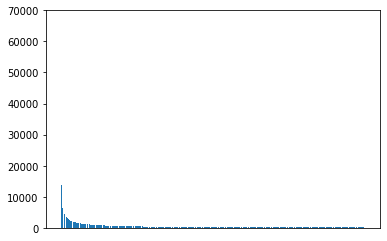

In [27]:
plt.bar(np.arange(len(no_trash_brand_list.index)), no_trash_brand_list.values)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)

In [28]:
no_trash_brand_list[:10]

바보사랑     66645
기타       64144
아디다스     32292
나이키      30785
아트박스     28518
1300K    20791
텐바이텐     15397
핫트랙스     14835
삼성전자     14770
오가닉맘     14694
Name: brand, dtype: int64

In [29]:
df[df['brand'] == "바보사랑"]['bcateid'].value_counts()[:10]

3     17821
11    13502
35     6519
16     4591
14     4351
8      2492
50     2188
20     1764
1      1434
49     1320
Name: bcateid, dtype: int64

- counts 상위 브랜드 : 대부분의 bcateid를 포함하기 때문에 큰 의미 없음.
- counts 하위 브랜드 : 갯수가 너무 많음 (long-tail)

#### check train brand in dev
- dev의 brand : 3%정도는 train에서 등장하지 않았던 브랜드

In [30]:
train_brand_dict = dict(df.brand.value_counts())

In [31]:
def check_brd_dict(pid):
    if pid in train_brand_dict:
        return 1
    else:
        return 0

test = dev_df.dropna(subset=['brand']).brand.apply(lambda x: check_brd_dict(x))

In [32]:
test.value_counts() ## --> dev의 brand는 train에서 3%정도는 등장하지 않았던 브랜드

1    252278
0      9771
Name: brand, dtype: int64

In [33]:
9771 / 252278

0.03873108237737734

#### brand normalized distribution

In [34]:
no_trash_brand_list = df[~df['brand'].isin(exception_brand_list)]['brand'].value_counts()

In [35]:
from scipy import stats

In [36]:
brand_z_list = stats.zscore(no_trash_brand_list.values)
print(brand_z_list.min())
print(brand_z_list.max())
print(len(brand_z_list))

-0.06294202190025026
220.3748984343736
193211


In [37]:
datamin = -5
datamax = 5
numbins = 1000
mybins = np.linspace(datamin, datamax, numbins)

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

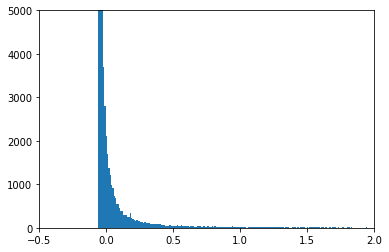

In [38]:
plt.ylim(0, 5000)
plt.xlim(-0.5, 2)
plt.hist(brand_z_list, bins=mybins)

In [39]:
len(brand_z_list[np.where((0 < brand_z_list) & (brand_z_list < 0.5))])

15566

# 브랜드 EDA 정리
- 결측값, 쓰레기값이 아닌 절반 정도의 브랜드 대상 (약 19만)
- 1차 필터링 : dev, test 데이터에 등장하는 브랜드
- 2차 필터링 : brand item cnt z-score -0.001 ~ 0.5 사이 -> 대부분의 일반 면적 커버
- insight : brand의 item cnt가 매우 높은 경우는 대부분의 카테고리에 해당하기 때문에 변별력 부족, 반대의 경우 데이터 부족
- 1~2차 필터링된 브랜드 외 -> 'another brand'로 정의

-----
-----

In [40]:
## 브랜드 정보는 없지만 제조사 정보만 있는 경우 : 약 30%
len(df[(df.maker.notnull()) & (df.brand.isnull())][['maker']]) / df.shape[0]

0.27929893453055743

In [41]:
maker_list = df.maker.value_counts().index.tolist()

exception_maker_dict = ["참조", "없음", "표기", "별도", "상세", "자체", "불명", "미입력"]
exception_maker_list = []

for maker in maker_list:
    if any(word in maker for word in exception_maker_dict):
        exception_maker_list.append(maker)

In [42]:
no_trash_unique_maker_list = df[(df.maker.notnull()) & (df.brand.isnull()) & ~df['maker'].isin(exception_maker_list)]['maker'].value_counts()

In [43]:
maker_z_list = stats.zscore(no_trash_unique_maker_list.values)
print(maker_z_list.min())
print(maker_z_list.max())
print(len(maker_z_list))

-0.005098548076969417
226.12178704761467
51134


In [44]:
datamin = -5
datamax = 5
numbins = 5000
mybins = np.linspace(datamin, datamax, numbins)

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([-5.       , -4.9979996, -4.9959992, ...,  4.9959992,  4.9979996,
         5.       ]),
 <a list of 4999 Patch objects>)

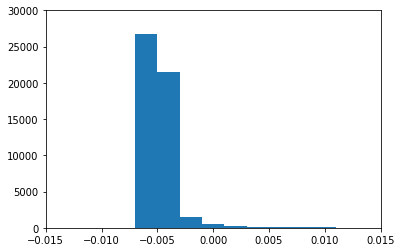

In [45]:
plt.ylim(0, 30000)
plt.xlim(-0.015, 0.015)
plt.hist(maker_z_list, bins=mybins)

In [46]:
len(brand_z_list[np.where((-0.003 < brand_z_list) & (brand_z_list < 0.01))])

2558

# 제조사 EDA 정리
- 1차 필터링 : 결측값, 쓰레기값이 아닌 메이커 대상
- 2차 필터링 : 브랜드 없이 제조사만 등장하는 데이터에 등장하는 제조사 :: -> 대부분은 브랜드가 상품력이 훨씬 높기 때문에, 브랜드를 포함하지 않은 데이터에서 상품력을 얼마나 발휘하는지의 여부를 측정. 브랜드와 동시 등장하는 제조사는 상품력이 매우 낮을 것으로 판단됨(가설)
- 3차 필터링 : z-score -0.003 ~ 0.01 사이 -> 대부분의 일반 면적 커버

-----
-----

#### price eda

In [61]:
pd.options.display.float_format = '{:.6f}'.format

In [48]:
df.price.describe()

count      8134818.00
mean         37072.31
std         920041.57
min             -1.00
25%             -1.00
50%             -1.00
75%          14680.00
max     1138466110.00
Name: price, dtype: float64

In [105]:
df[df['price']==-1].shape[0] / df.shape[0] ## price 결측 비율 64%

0.6479334878788929

In [146]:
df[df['price']!=-1]['price'].describe()

count      2863997.000000
mean        105300.996440
std        1548264.960339
min              1.000000
25%          12810.000000
50%          28240.000000
75%          70600.000000
max     1138466110.000000
Name: price, dtype: float64

In [97]:
df[(df['price']!=-1) & (df['price'] < 1000000)]['price'].describe()

count   2824493.000000
mean      67166.235912
std      114755.604384
min           1.000000
25%       12620.000000
50%       27710.000000
75%       67110.000000
max      999990.000000
Name: price, dtype: float64

In [145]:
df[(df['price']!=-1) & (df['price'] < 500000)]['price'].describe()

count   2774353.000000
mean      55904.636389
std       76881.679669
min           1.000000
25%       12460.000000
50%       26970.000000
75%       63160.000000
max      499980.000000
Name: price, dtype: float64

In [136]:
test_df = df[(df['price']!=-1) & (df['price'] < 500000)]
test_df['norm_price2'] = round((test_df['price'] - test_df['price'].min()) / (test_df['price'].max() - test_df['price'].min()),1)

/root/no-error/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [137]:
price_list = test_df.norm_price2.value_counts()

In [142]:
price_list.values

array([1314720,  865761,  260504,  123758,   73507,   47733,   31272,
         22143,   16468,   12874,    5613])

<BarContainer object of 11 artists>

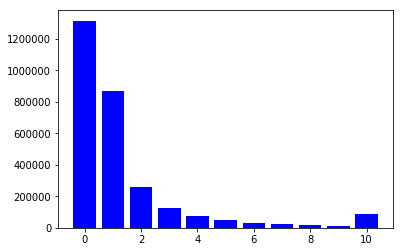

In [144]:
y = [1314720,  865761,  260504,  123758,   73507,   47733,   31272,
         22143,   16468,   12874,    89379]
N = len(y)
x = range(N)
plt.bar(x, y, color="blue")

In [120]:
df[df['price'] > 500000].shape

(89379, 11)

In [149]:
print("quantile 1", str(df[df['price']!=-1]['price'].quantile(0.15)))
print("quantile 2", str(df[df['price']!=-1]['price'].quantile(0.75)))

quantile 1 8310.0
quantile 2 70600.0


# Price EDA 정리
- step 1 : 약 64% 비중 결측값 제외하고 상위 (15, 75) quantile을 구함
- step 2 : quantile을 기준으로 상,중,하 categorical하게 price 분리
- 결측값 처리방법 : '중' 가격으로 분류
- price category를 몇개로 할 지는 연구 필요

###### 가설
- 이렇게 하면 고가품 outlier 처리 가능. 
- 가격은 카테고리 내에서의 차이를 구분하는 것에는 의미가 있지만, 카테고리 간의 차이를 구분하는 것에는 너무 케바케임
- 3개정도로 의미를 희석시키는 것이 다량의 결측을 처리하기에도 용이하고, 비슷한 가격대의 수많은 다른 카테고리를 구분할 필요도 없어지지 않을까

-----
-----

#### 날짜 피처 eda : 
- train, dev, test 중 max - 1540738800.0 (10월 29일)
- 모든 데이터에서 결측치 없음

In [4]:
max_unix_time = 1540738800
def get_unix_time_aging(time_str):
    date_str = time_str[2:10]
    unix_time = time.mktime(datetime.datetime.strptime(date_str, "%Y%m%d").timetuple())
    return (max_unix_time - unix_time)

def get_unix_time(time_str):
    date_str = time_str[2:10]
    unix_time = time.mktime(datetime.datetime.strptime(date_str, "%Y%m%d").timetuple())
    return (unix_time)

def get_year_month(time_str):
    return time_str[2:8]

In [5]:
# dev_df = pd.read_csv(data_path + "dev_sample.csv")
# test_df = pd.read_csv(data_path + "test_sample.csv")

In [206]:
# df['unix_time'] = df['updttm'].apply(lambda x: get_unix_time(x))
# dev_df['unix_time'] = dev_df['updttm'].apply(lambda x: get_unix_time(x))
# test_df['unix_time'] = test_df['updttm'].apply(lambda x: get_unix_time(x))

In [207]:
# print(df['unix_time'].max())
# print(dev_df['unix_time'].max())
# print(test_df['unix_time'].max())

#### 카테고리별 aging 및 unix time 분포

In [217]:
df['unix_time_aging'] = df['updttm'].apply(lambda x: get_unix_time_aging(x))
df['unix_time'] = df['updttm'].apply(lambda x: get_unix_time(x))
df['unix_time_norm'] = (df['unix_time'] - df['unix_time'].min()) / (df['unix_time'].max() - df['unix_time'].min())
df['unix_time_norm2'] = (df['unix_time_aging'] - df['unix_time_aging'].min()) / (df['unix_time_aging'].max() - df['unix_time_aging'].min())

In [7]:
df['year_mon'] = df['updttm'].apply(lambda x: get_year_month(x))
test_df['year_mon'] = test_df['updttm'].apply(lambda x: get_year_month(x))
dev_df['year_mon'] = dev_df['updttm'].apply(lambda x: get_year_month(x))

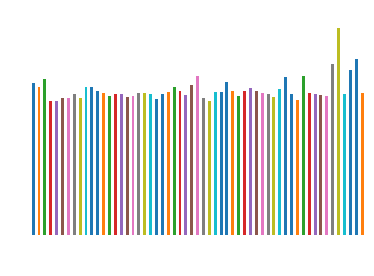

In [213]:
plt.axis('off')
df.groupby('bcateid')['unix_time_aging'].mean().plot.bar()

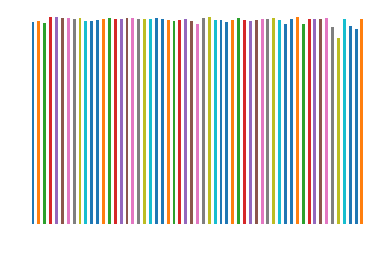

In [196]:
plt.axis('off')
df.groupby('bcateid')['unix_time_norm'].mean().plot.bar()

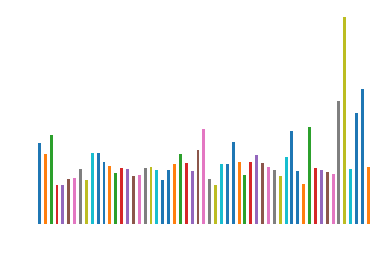

In [218]:
plt.axis('off')
df.groupby('bcateid')['unix_time_norm2'].mean().plot.bar()

In [14]:
df[df['year_mon']=="201804"]['bcateid'].value_counts()[:10]

14    378815
9     309361
16    292054
17    253725
35    237485
28    224943
11    205418
24    205187
6     204967
20    202568
Name: bcateid, dtype: int64

In [15]:
df[df['year_mon']=="201711"]['bcateid'].value_counts()[:10]

53    12485
3      4609
12     2684
14     2301
11     2182
35     1690
16     1568
9      1472
7      1418
28     1158
Name: bcateid, dtype: int64

In [16]:
df['year_mon'].value_counts()

201804    5176945
201803    1796579
201802     370492
201712     355915
201801     143679
201711      48204
201706      30471
201709      27086
201707      24497
201710      21334
201708      19381
201612      15707
201605      13388
201701      12994
201705       9662
201704       8800
201703       8796
201607       8784
201702       7763
201609       6808
201512       6491
201606       6293
201610       3843
201611       3117
201608       2329
201603       1645
201604       1257
201601        753
201510        676
201602        532
201509        213
201511        135
201508         53
201505         44
201507         44
201503         40
201504         35
201506         33
Name: year_mon, dtype: int64

In [10]:
dev_df['year_mon'].value_counts()

201810    269805
201809     86932
201804     78503
201808     19319
201803     19126
201806     14382
201807      7771
201802      3468
201712      1762
201805      1483
201801      1247
201706       753
201711       608
201710       345
201707       340
201709       223
201605       218
201612       180
201708       167
201702       153
201701       133
201607       101
201606        97
201703        87
201704        84
201705        78
201603        64
201512        60
201610        55
201609        41
201611        41
201510        37
201608        36
201604        25
201601        14
201602        12
201511         9
201508         8
201503         5
201509         4
201506         2
201504         2
201507         2
201505         1
Name: year_mon, dtype: int64

In [11]:
test_df['year_mon'].value_counts()

201810    813724
201809    261358
201804    233272
201803     57804
201808     57296
201806     43252
201807     23919
201802     10602
201712      5090
201805      4449
201801      3755
201706      2290
201711      1716
201710      1050
201707       968
201709       677
201605       643
201708       567
201612       508
201701       460
201702       427
201607       370
201704       262
201606       251
201703       248
201705       240
201610       229
201512       209
201603       197
201510       124
201611       115
201608       111
201609       110
201604        79
201602        33
201601        27
201509        25
201511        17
201508        13
201503        10
201506        10
201505         9
201507         6
201504         1
Name: year_mon, dtype: int64

In [ ]:
plt.axis('off')
test_df.groupby('bcateid')['unix_time_norm2'].mean().plot.bar()

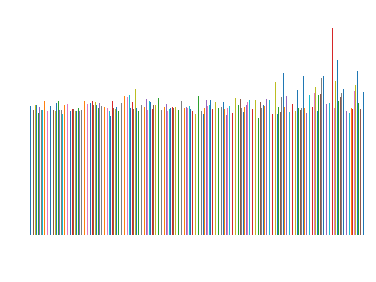

In [214]:
plt.axis('off')
df.groupby('mcateid')['unix_time_aging'].mean().plot.bar()

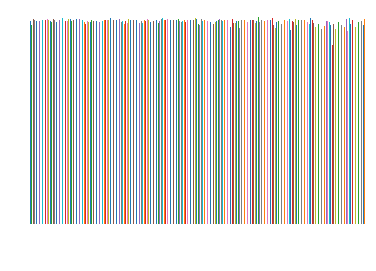

In [197]:
plt.axis('off')
df.groupby('mcateid')['unix_time_norm'].mean().plot.bar()

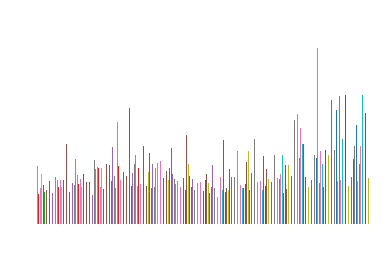

In [220]:
plt.axis('off')
df.groupby('mcateid')['unix_time_norm2'].mean().plot.bar()

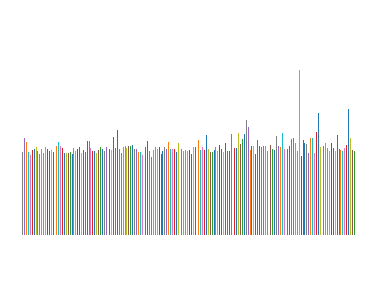

In [215]:
plt.axis('off')
df.groupby('scateid')['unix_time_aging'].mean().plot.bar()

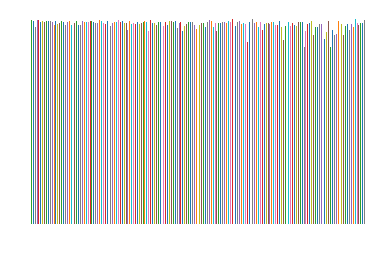

In [198]:
plt.axis('off')
df.groupby('scateid')['unix_time_norm'].mean().plot.bar()

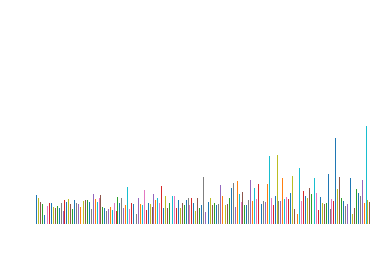

In [221]:
plt.axis('off')
df.groupby('scateid')['unix_time_norm2'].mean().plot.bar()

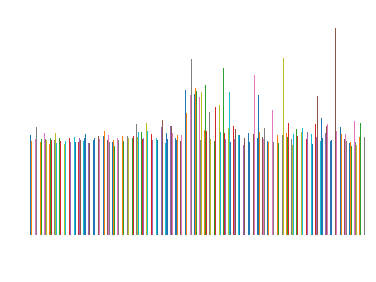

In [216]:
plt.axis('off')
df.groupby('dcateid')['unix_time_aging'].mean().plot.bar()

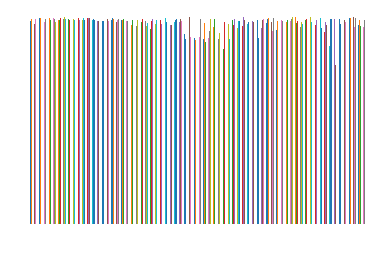

In [199]:
plt.axis('off')
df.groupby('dcateid')['unix_time_norm'].mean().plot.bar()

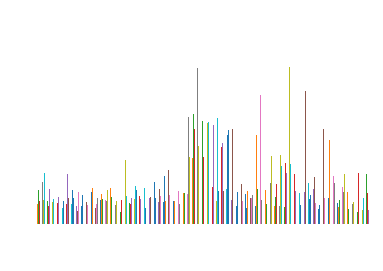

In [222]:
plt.axis('off')
df.groupby('dcateid')['unix_time_norm2'].mean().plot.bar()

# updttm EDA 정리
- train, dev, test 결측값 없음
- train은 4월 30일이 max
- dev, test는 10월 29일이 max

###### step
- 1. train : 5월 1일 기준으로 current-updttm unix time aging 계산 후 min-max scaling
- 2. dev, test : 10월 30일 기준으로 적용
- 3. result : 상품의 최신 업데이트 상태를 나타내는 unix time aging 피처 // 상품이 최근 업데이트 된 계절을 나타내는 update_season 피처 생성

###### 가설
- 업데이트가 자주 되는 상품군이 존재할 것. 그래서 aging을 활용할 수 있지 않을까
- 계절마다 업데이트 되는 상품군 역시 존재할 것.